In [14]:
import scanpy as sc
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
import os 

In [3]:
maindir='figures'
answer=os.path.isdir(maindir)
if answer==True:
    pass
else:
    os.mkdir(maindir)

In [45]:

adata=sc.read_h5ad('sc_genes_spatial_cell.h5ad')

In [6]:
adata

AnnData object with n_obs × n_vars = 87210 × 18541
    obs: 'uniform_density', 'rna_count_based_density'
    var: 'n_cells', 'sparsity', 'is_training'
    uns: 'overlap_genes', 'training_genes'

In [8]:
cellname=adata.obs_names.to_numpy()
genename=adata.var_names.to_numpy()
print(len(cellname),len(genename),cellname[0:5],genename[0:5])

87210 18541 ['cell394990' 'cell394991' 'cell394992' 'cell394993' 'cell394994'] ['sox17' 'mrpl15' 'lypla1' 'gm37988' 'tcea1']


In [11]:
adata.var['mt']=adata.var_names.str.startswith('mt-')
sc.pp.calculate_qc_metrics(adata,qc_vars=['mt'],percent_top=None,log1p=False,inplace=True)

/home/sclab/miniconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/sclab/miniconda3/lib/python3.9/site-packages/seaborn/distributions.py:2657: RuntimeWarning: Mean of empty slice.
  line, = ax.plot(a.mean(), 0)
/home/sclab/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


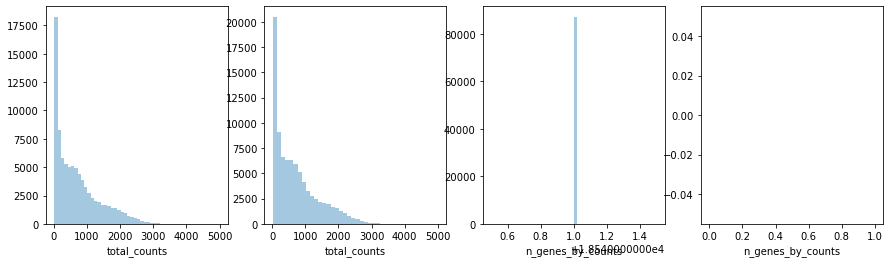

In [15]:
fig, axs = plt.subplots(1, 4, figsize=(15, 4))
sns.distplot(adata.obs["total_counts"], kde=False, ax=axs[0])
sns.distplot(adata.obs["total_counts"][adata.obs["total_counts"] < 10000], kde=False, bins=40, ax=axs[1])
sns.distplot(adata.obs["n_genes_by_counts"], kde=False, bins=60, ax=axs[2])
sns.distplot(adata.obs["n_genes_by_counts"][adata.obs["n_genes_by_counts"] < 4000], kde=False, bins=60, ax=axs[3])
fig.savefig('figures/total_counts_and_n_genes_by_counts.png')

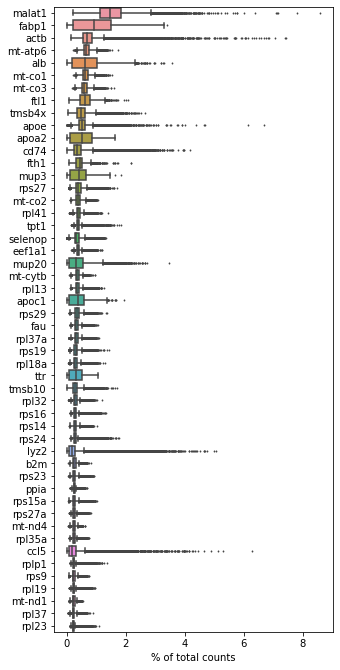

In [17]:
sc.pl.highest_expr_genes(adata,n_top=50,show=True,save='.png')

In [18]:
adata = adata[adata.obs["pct_counts_mt"] < 20]
print(f"#cells after MT filter: {adata.n_obs}")

#cells after MT filter: 87210


In [56]:
#follow this tutorial https://nbisweden.github.io/workshop-scRNAseq/labs/compiled/scanpy/scanpy_01_qc.html

malat1 = adata.var_names.str.startswith('malat1')
# we need to redefine the mito_genes since they were first 
# calculated on the full object before removing low expressed genes.
mito_genes = adata.var_names.str.startswith('mt-')
#hb_genes = adata.var_names.str.contains('^HB[^(P)]')
ribo_genes= adata.var_names.str.startswith('rps')|adata.var_names.str.startswith('rpl')
gm_genes=adata.var_names.str.startswith('gm')

remove = np.add(mito_genes, malat1)
#remove = np.add(remove, hb_genes)
remove = np.add(remove, ribo_genes)
remove = np.add(remove, gm_genes)


keep = np.invert(remove)

adata = adata[:,keep]

print(adata.n_obs, adata.n_vars)

87210 16418


/home/sclab/miniconda3/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:155: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


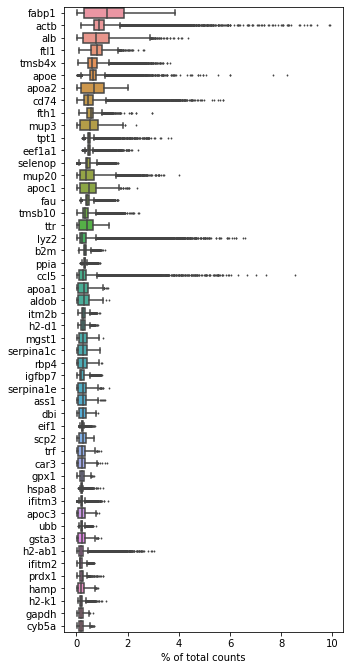

In [57]:
sc.pl.highest_expr_genes(adata,n_top=50,show=True)

In [25]:
fw=open('temp.dat','w')
for i in range(len(genename)):
    fw.write(genename[i]+'\n')

normalize (87210, 16418)


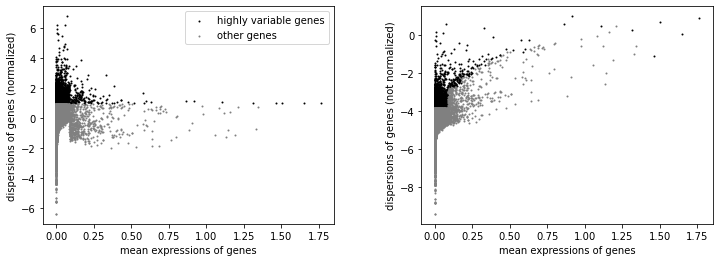

In [58]:
sc.pp.normalize_total(adata, inplace=True)
sc.pp.log1p(adata)
print('normalize',adata.shape)

sc.pp.highly_variable_genes(adata, flavor="seurat", n_top_genes=2000)
sc.pl.highly_variable_genes(adata,show=True,save='.png')


In [59]:
adata = adata[:, adata.var.highly_variable]
adata

View of AnnData object with n_obs × n_vars = 87210 × 2000
    obs: 'uniform_density', 'rna_count_based_density'
    var: 'n_cells', 'sparsity', 'is_training', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'overlap_genes', 'training_genes', 'log1p', 'hvg'

In [61]:
sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
#sc.tl.louvain(adata,resolution=1.0)
sc.tl.leiden(adata,resolution=1.0)

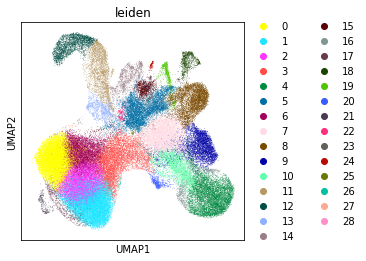

In [63]:
plt.rcParams["figure.figsize"] = (4, 4)
#sc.pl.umap(adata, color=["leiden","total_counts",  "n_genes_by_counts"], wspace=0.4,show=True, save='1.png')

sc.pl.umap(adata, color=["leiden"], wspace=0.4,show=True, save='leiden.png')


/home/sclab/miniconda3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:394: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'names'] = self.var_names[global_indices]
/home/sclab/miniconda3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:396: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'scores'] = scores[global_indices]
/home/sclab/miniconda3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:399: PerformanceWarning: DataFrame is highly frag

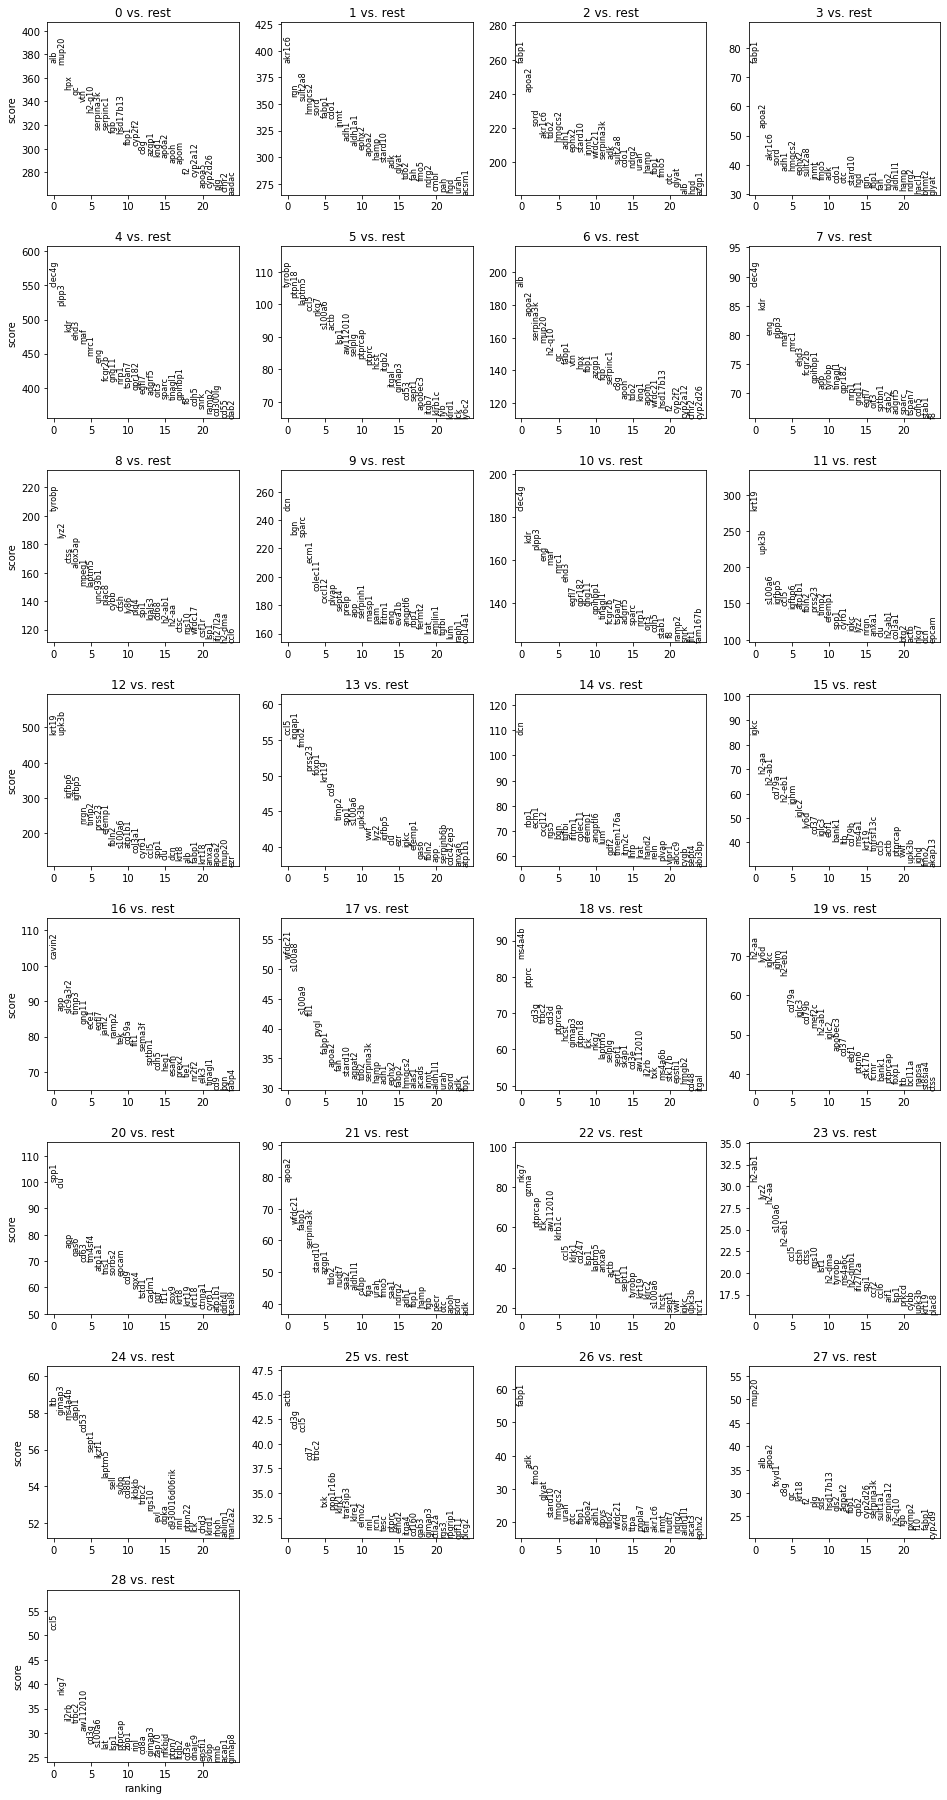

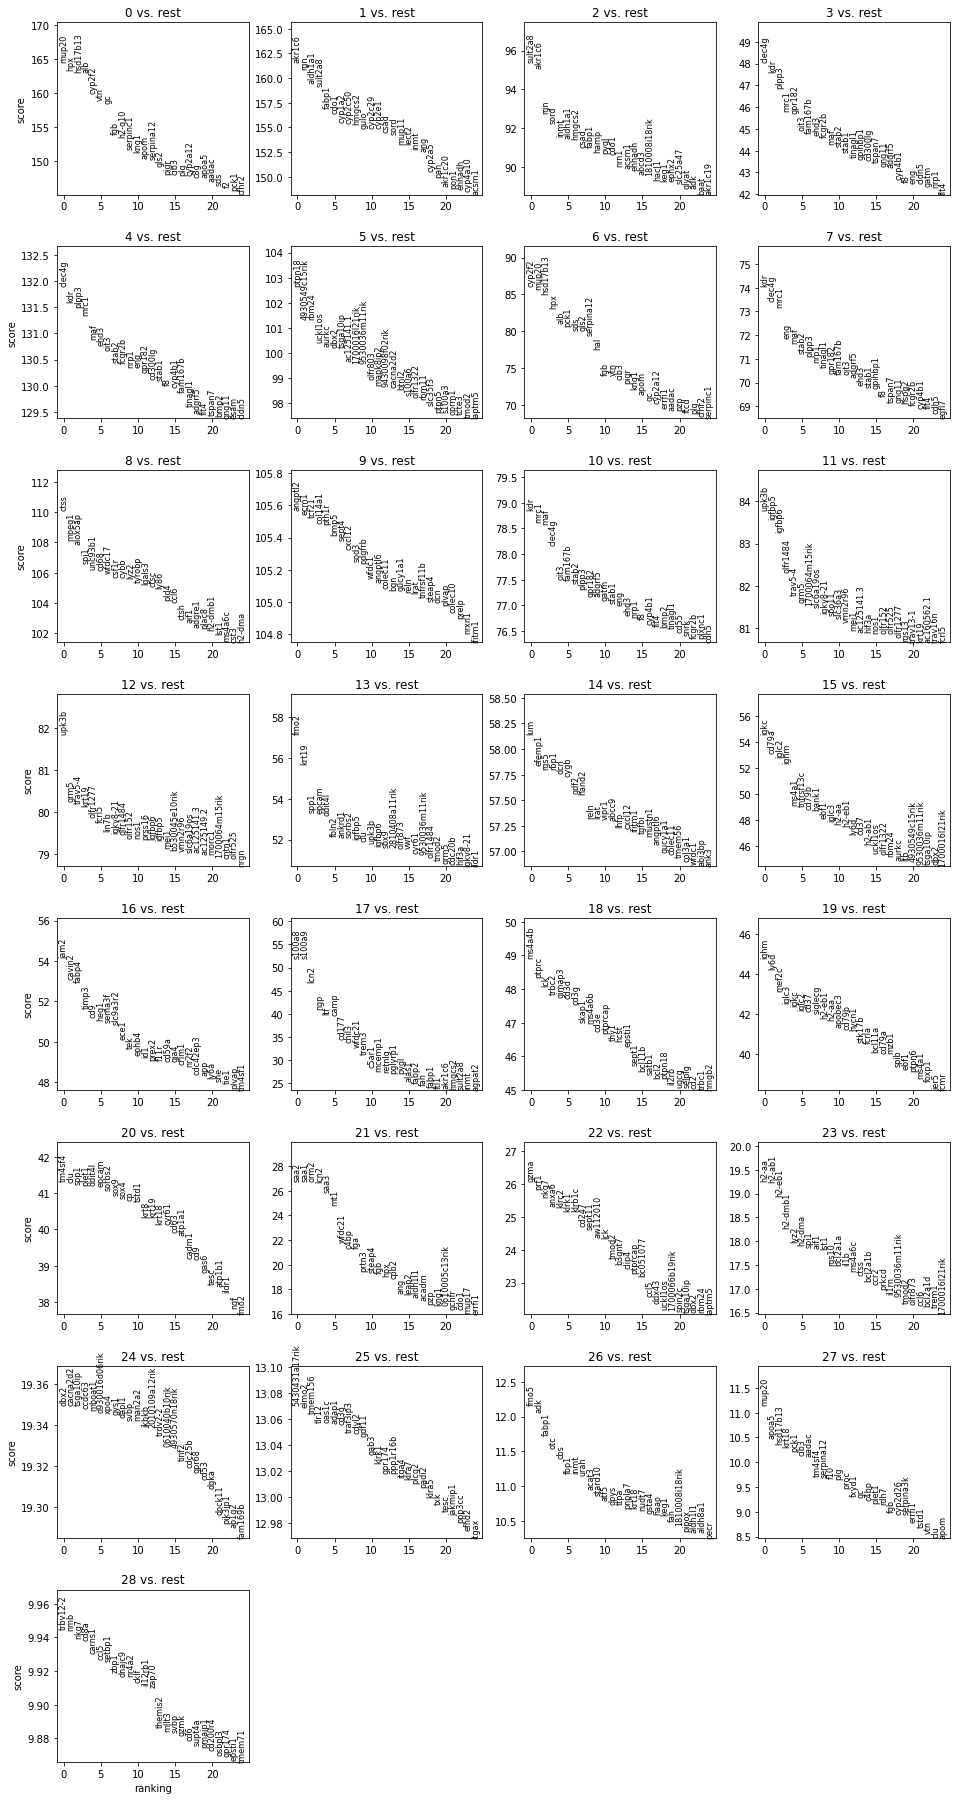

/home/sclab/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


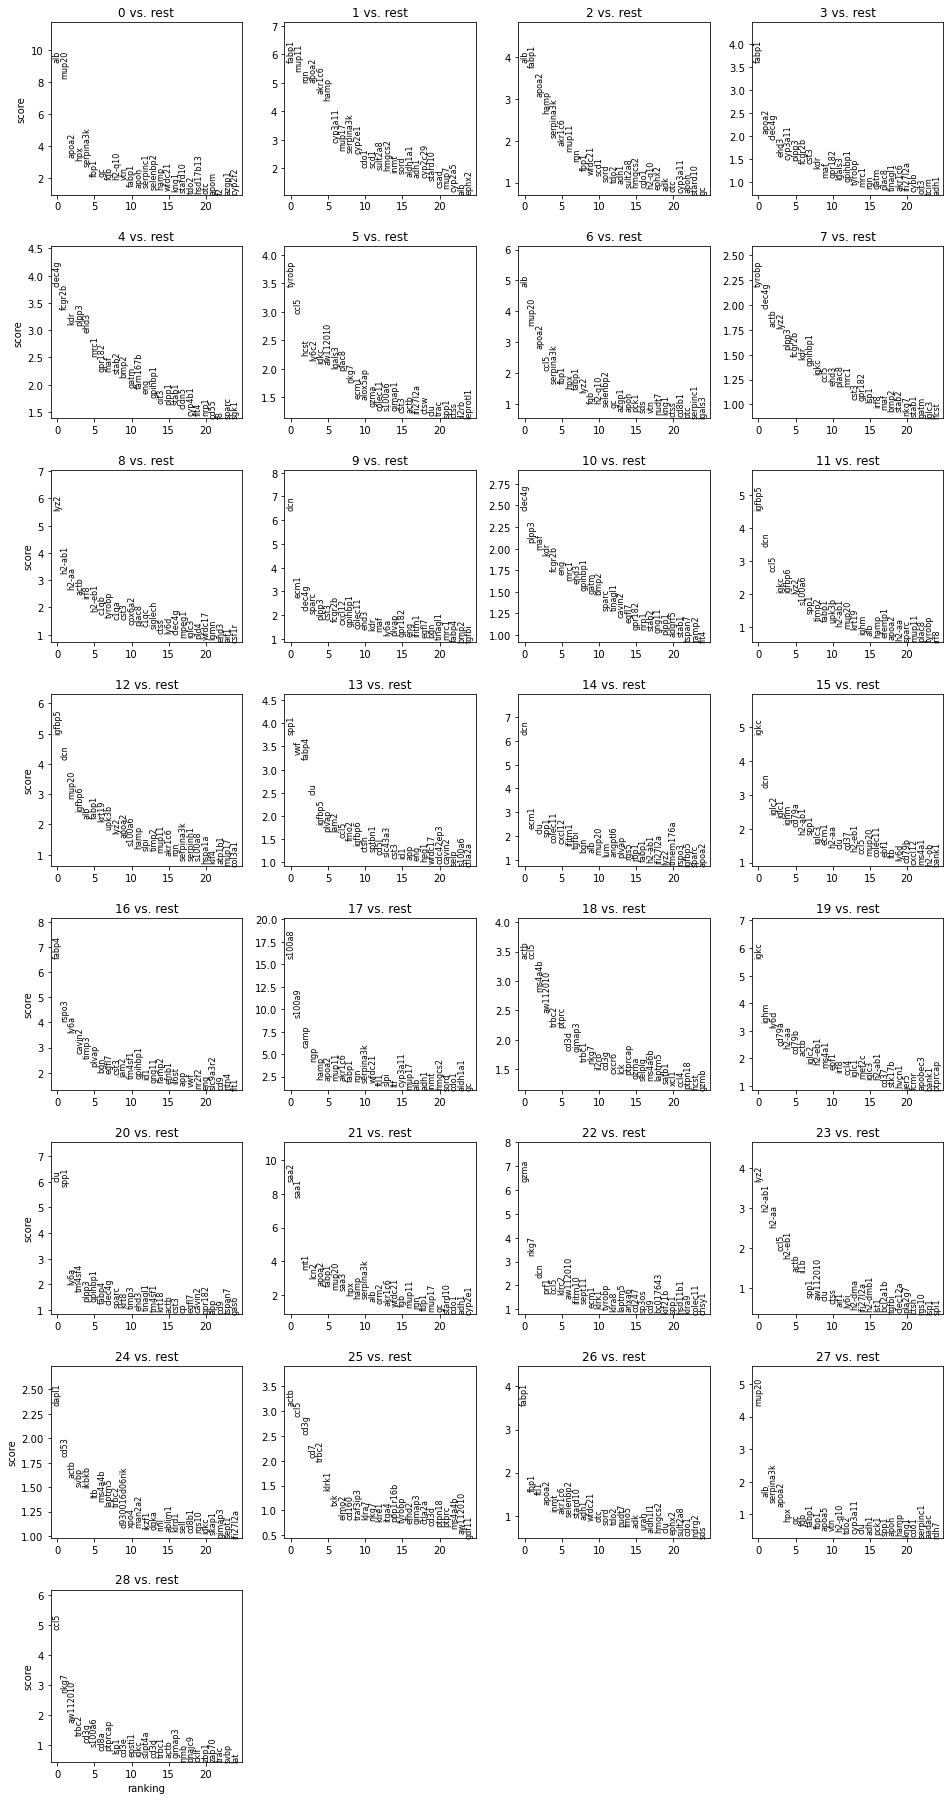

In [64]:
sc.tl.rank_genes_groups(adata, 'leiden', method='t-test')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False, show=True, save='_t-test.png')

sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False,show=True, save='_wilcoxon.png')

sc.tl.rank_genes_groups(adata, 'leiden', method='logreg')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False,show=True, save='_logreg.png')

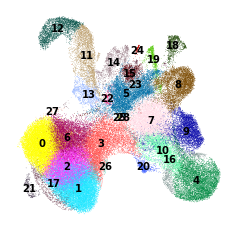

In [68]:


plt.rcParams["figure.figsize"] = (4, 4)
new_cluster_names = ['0','1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19','20','21','22','23','24','25','26','27','28']
adata.rename_categories('leiden', new_cluster_names)
sc.pl.umap(adata, color='leiden',legend_loc='on data', title='', frameon=False,show=True, save='new_leiden2.png')

In [70]:
adata.write_h5ad('figures/saveall')
adata.obs.leiden.to_csv('figures/leiden_output.dat',header=True)
df=pd.DataFrame(data=adata.X.transpose(), index=adata.var_names , columns=adata.obs_names)
df.to_csv("filter_genes_tangram_mapping.csv")

In [73]:
#cellname=adata.obs_names.to_numpy()
#genename=adata.var_names.to_numpy()


154


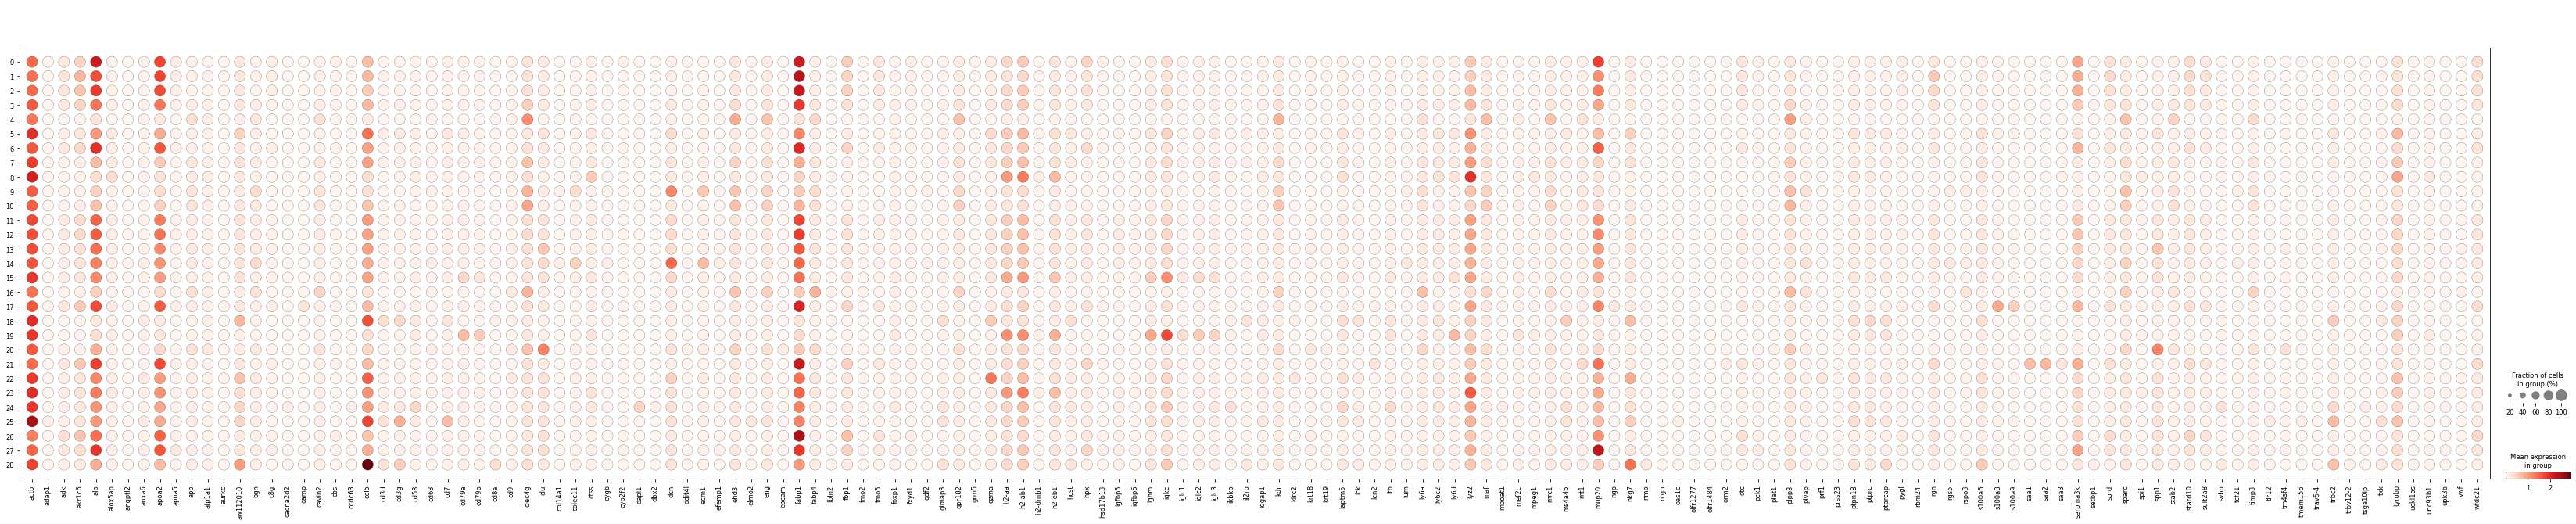

In [72]:
marker_genes=['alb', 'mup20', 'hpx', 'hsd17b13', 'cyp2f2',
'akr1c6', 'rgn', 'sult2a8', 'fabp1',
'fabp1', 'apoa2', 'sord', 'akr1c6',
'fabp1', 'apoa2', 'clec4g', 'gpr182', 'plpp3', 'kdr',
'clec4g', 'plpp3', 'kdr', 'maf', 'ehd3',
'tyrobp', 'ptpn18', 'ccl5', 'laptm5', 'rbm24', 'uckl1os', 'aurkc','dbx2','igkc','hcst','ly6c2',
'alb', 'apoa2', 'serpina3k', 'mup20', 'hsd17b13', 'cyp2f2','ccl5',
'clec4g', 'kdr', 'eng', 'plpp3', 'mrc1', 'maf', 'stab2', 'tyrobp',
'lyz2', 'ctss', 'alox5ap', 'mpeg1', 'spi1', 'h2-ab1', 'h2-aa', 'unc93b1',
'dcn', 'sparc', 'ecm1', 'angptl2', 'tcf21', 'bgn', 'col14a1', 'colec11',
'clec4g', 'kdr', 'plpp3', 'maf',
'igfbp5', 'igfbp6', 'ccl5', 'upk3b', 'krt19', 's100a6','trav5-4','dcn','igkc','olfr1484',
'krt19', 'upk3b', 'igfbp5', 'igfbp6', 'trav5-4','dcn','mup20','alb','nrgn','grm5','olfr1277',
'epcam', 'spp1','vwf', 'fmo2', 'fabp4', 'ccl5', 'iqgap1', 'plvap', 'clu', 'prss23','foxp1','krt19','ddit4l','fbln2','igfbp5',
'dcn', 'ecm1', 'clu','spp1','colec11', 'efemp1', 'lum', 'rgs5','cygb','gdf2',
'igkc', 'cd79a', 'ighm', 'iglc2', 'iglc1', 'h2-aa', 'h2-ab1', 'h2-eb1',
'cavin2', 'timp3', 'fabp4', 'ly6a', 'plvap', 'rspo3', 'cd9' ,
's100a8', 's100a9', 'camp', 'wfdc21', 'pygl', 'lcn2', 'ngp',
'ptprc', 'trbc2', 'cd3d', 'gimap3', 'ms4a4b','cd3g','ccl5','actb','lck',
'ly6d', 'igkc', 'ighm', 'h2-aa', 'h2-eb1', 'cd79a', 'cd79b','mef2c','iglc3',
'spp1', 'clu', 'tm4sf4', 'ly6a', 'cd63', 'plet1','plpp3','ddit4l','app','atp1a1',
'apoa2', 'fabp1', 'mt1', 'saa1', 'saa2','saa3', 'serpina3k', 'lcn2','wfdc21','stard10','orm2',
'nkg7', 'gzma', 'prf1', 'ptprcap', 'klrc2', 'anxa6', 'lck','aw112010','dcn','ccl5',
'lyz2', 'h2-aa', 'h2-ab1', 'h2-eb1', 's100a6', 'actb', 'h2-dmb1',
'gimap3', 'ltb', 'ms4a4b', 'dapl1', 'cd53', 'dbx2','actb', 'laptm5', 'svbp','ccdc63','tsga10ip','mboat1','cacna2d2','ikbkb',
'actb', 'cd3g', 'ccl5', 'cd7', 'trbc2', 'adap1', 'elmo2','tmem156','txk','oas1c','tlr12',
'fabp1', 'adk','fmo5', 'otc', 'cbs', 'fbp1',
'mup20', 'alb', 'apoa2', 'hsd17b13','apoa5','serpina3k','pck1','krt18','hpx','c8g','fxyd1',
'ccl5', 'nkg7', 'trbc2', 'aw112010', 'trbv12-2', 'cd3g', 'nmb', 'cd8a','il2rb','setbp1']

marker_genes=sorted(list(set(marker_genes)))
print(len(marker_genes))
sc.pl.dotplot(adata, marker_genes, groupby='leiden',show=True,save='_dot_plot_GM_leiden.png')